In [4]:
import numpy as np
import scipy.io.wavfile as wav
from scipy import signal
import matplotlib.pyplot as plt


In [5]:
# Load the WAV file
rate, data = wav.read("myvoice.wav")

print("Sample Rate:", rate)
print("Audio shape:", data.shape)

Sample Rate: 48000
Audio shape: (538456,)


Step 2: Normalize and Convert to 8-bit PCM

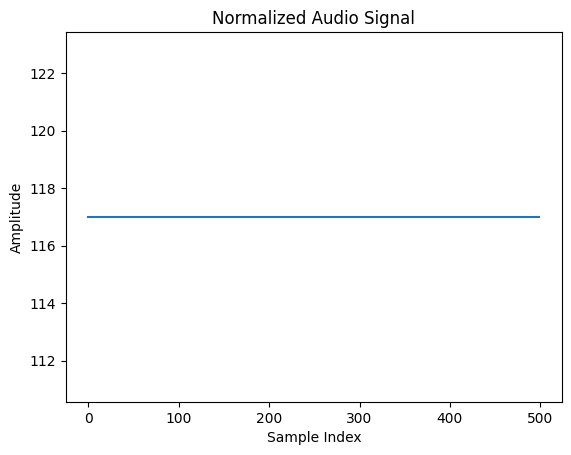

In [6]:
# If stereo, convert to mono
if len(data.shape) > 1:
    data = data.mean(axis=1)

# Normalize to 0-255 and convert to 8-bit unsigned int
normalized_data = ((data - np.min(data)) / (np.max(data) - np.min(data)) * 255).astype(np.uint8)

# Plot a snippet of audio
plt.plot(normalized_data[:500])
plt.title("Normalized Audio Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()


Step 3: Convert to Bitstream

In [7]:
# Convert each sample to 8-bit binary and flatten into a bitstream
bitstream = np.unpackbits(normalized_data)

print("Bitstream length:", len(bitstream))
print("First 64 bits:", bitstream[:64])


Bitstream length: 4307648
First 64 bits: [0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0
 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1]


Step 4: Channel Encoding with Hamming (7,4)

In [9]:
import numpy as np

def hamming74_encode(bits):
    # Assuming bits is an iterable of 4 bits (0 or 1)
    d1, d2, d3, d4 = bits
    p1 = (d1 + d2 + d4) % 2
    p2 = (d1 + d3 + d4) % 2
    p3 = (d2 + d3 + d4) % 2
    return np.array([p1, p2, d1, p3, d2, d3, d4], dtype=np.uint8)

# Pad bitstream to make its length a multiple of 4
pad_len = (4 - len(bitstream) % 4) % 4
padded_bits = np.concatenate([bitstream, np.zeros(pad_len, dtype=np.uint8)])

# Reshape to groups of 4
bit_groups = padded_bits.reshape((-1, 4))

# Encode each group using Hamming (7,4)
encoded_bits = np.array([hamming74_encode(bits) for bits in bit_groups])
encoded_stream = encoded_bits.flatten().astype(np.uint8)

print("Original bitstream length:", len(bitstream))
print("Encoded stream length:", len(encoded_stream))


Original bitstream length: 4307648
Encoded stream length: 7538384


Step 5: BPSK Modulation

In [10]:
# BPSK modulation: 0 -> -1, 1 -> +1
modulated_signal = 2 * encoded_stream - 1

print("First 20 modulated symbols:", modulated_signal[:20])


First 20 modulated symbols: [255 255 255   1   1   1   1 255   1 255 255   1 255   1 255 255 255   1
   1   1]


Step 6: Add Noise (AWGN Channel)

In [11]:
def add_awgn_noise(signal, EbN0_dB):
    EbN0 = 10 ** (EbN0_dB / 10)  # Convert dB to linear scale
    power = np.mean(signal ** 2)  # Signal power
    noise_power = power / EbN0
    noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
    return signal + noise


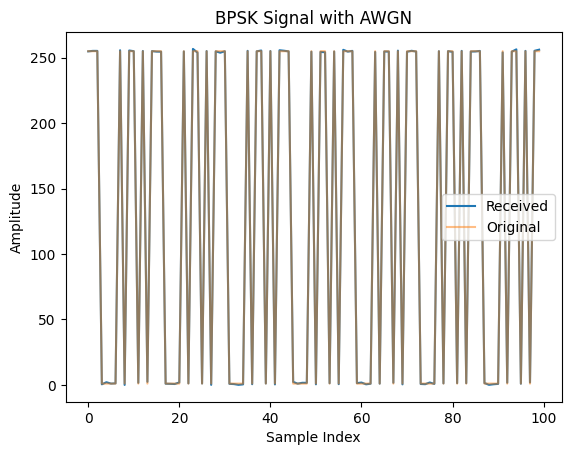

In [12]:
EbN0_dB = 5  # You can change this to simulate different noise levels
received_signal = add_awgn_noise(modulated_signal, EbN0_dB)

# Plot a small section of the received signal
import matplotlib.pyplot as plt
plt.plot(received_signal[:100], label="Received")
plt.plot(modulated_signal[:100], label="Original", alpha=0.5)
plt.title("BPSK Signal with AWGN")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


Step 7: BPSK Demodulation

In [13]:
# BPSK demodulation
demodulated_bits = (received_signal >= 0).astype(np.uint8)

print("First 20 demodulated bits:", demodulated_bits[:20])


First 20 demodulated bits: [1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]


Step 8: Hamming (7,4) Decoding

In [15]:
def hamming74_decode(codeword):
    # codeword: array of 7 bits: [p1, p2, d1, p3, d2, d3, d4]
    p1, p2, d1, p3, d2, d3, d4 = codeword
    # Calculate syndrome bits
    s1 = (p1 + d1 + d2 + d4) % 2
    s2 = (p2 + d1 + d3 + d4) % 2
    s3 = (p3 + d2 + d3 + d4) % 2
    syndrome = s1 + (s2 << 1) + (s3 << 2)
    
    corrected_codeword = codeword.copy()
    if syndrome != 0:
        # Convert syndrome to error position (1-indexed)
        error_index = syndrome - 1
        # Correct the error by flipping the bit
        corrected_codeword[error_index] = (corrected_codeword[error_index] + 1) % 2

    # Extract data bits: positions 2, 4, 5, 6
    decoded = [corrected_codeword[2], corrected_codeword[4], corrected_codeword[5], corrected_codeword[6]]
    return decoded, syndrome

# Ensure the bitstream length is a multiple of 7
trim_len = len(demodulated_bits) - (len(demodulated_bits) % 7)
demodulated_bits = demodulated_bits[:trim_len]

# Reshape into 7-bit blocks
received_blocks = demodulated_bits.reshape((-1, 7))

# Decode using Hamming (7,4)
decoded_bits = []
for block in received_blocks:
    decoded, _ = hamming74_decode(block)
    decoded_bits.extend(decoded)

decoded_bits = np.array(decoded_bits, dtype=np.uint8)

print("Recovered data bitstream length:", len(decoded_bits))
print("First 32 recovered bits:", decoded_bits[:32])

# Ensure the bitstream length is a multiple of 7
trim_len = len(demodulated_bits) - (len(demodulated_bits) % 7)
demodulated_bits = demodulated_bits[:trim_len]

# Reshape into 7-bit blocks
received_blocks = demodulated_bits.reshape((-1, 7))

# Decode using Hamming (7,4)
decoded_bits = []
for block in received_blocks:
    decoded, _ = hamming74_decode(block)
    decoded_bits.extend(decoded)

decoded_bits = np.array(decoded_bits, dtype=np.uint8)

print("Recovered data bitstream length:", len(decoded_bits))
print("First 32 recovered bits:", decoded_bits[:32])


Recovered data bitstream length: 4307648
First 32 recovered bits: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Recovered data bitstream length: 4307648
First 32 recovered bits: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Step 9: Reconstruct Audio from Bitstream

In [16]:
# Ensure length is a multiple of 8
final_len = len(decoded_bits) - (len(decoded_bits) % 8)
decoded_bits = decoded_bits[:final_len]

# Group into bytes
byte_data = np.packbits(decoded_bits)

# Convert back to int16 audio scale (reverse of earlier normalization)
restored_audio = byte_data.astype(np.float32) / 255.0
restored_audio = restored_audio * (np.max(data) - np.min(data)) + np.min(data)
restored_audio = restored_audio.astype(np.int16)


In [17]:
from scipy.io.wavfile import write

write("reconstructed.wav", rate, restored_audio)
print("✅ Reconstructed audio saved as 'reconstructed.wav'")


✅ Reconstructed audio saved as 'reconstructed.wav'


Step 10: Bit Error Rate (BER) Calculation

In [18]:
# Compare only the original number of bits before encoding
original_bits = bitstream[:len(decoded_bits)]

# BER = (Number of incorrect bits) / (Total bits)
bit_errors = np.sum(original_bits != decoded_bits)
ber = bit_errors / len(original_bits)

print(f"🔍 Bit Error Rate (BER): {ber:.6f} ({bit_errors} bit errors out of {len(original_bits)})")


🔍 Bit Error Rate (BER): 0.429604 (1850583 bit errors out of 4307648)


Step 11: BER vs. Eb/N0 Plot

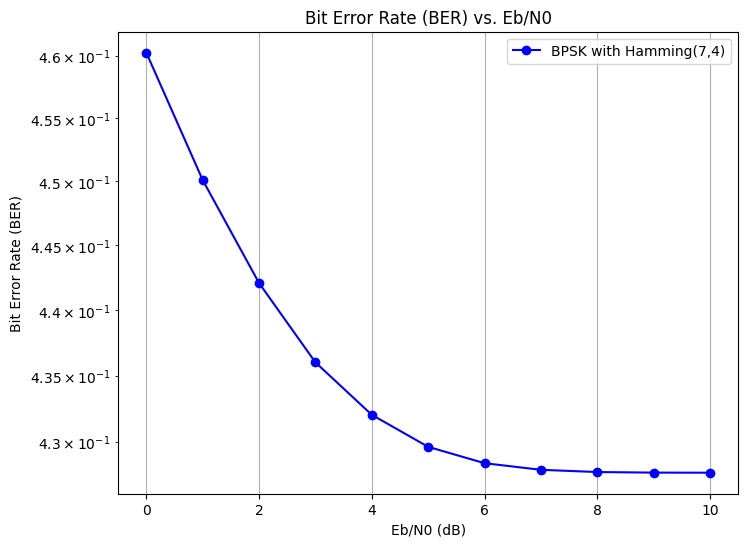

In [19]:
# List of Eb/N0 values (dB)
EbN0_dB_range = np.arange(0, 11, 1)
ber_values = []

for EbN0_dB in EbN0_dB_range:
    # Add AWGN noise at current Eb/N0 value
    noisy_signal = add_awgn_noise(modulated_signal, EbN0_dB)

    # Demodulate
    demodulated_bits = (noisy_signal >= 0).astype(np.uint8)

    # Decode using Hamming (7,4)
    trim_len = len(demodulated_bits) - (len(demodulated_bits) % 7)
    demodulated_bits = demodulated_bits[:trim_len]
    received_blocks = demodulated_bits.reshape((-1, 7))

    decoded_bits = []
    for block in received_blocks:
        decoded, _ = hamming74_decode(block)
        decoded_bits.extend(decoded)

    decoded_bits = np.array(decoded_bits, dtype=np.uint8)

    # Calculate BER
    original_bits = bitstream[:len(decoded_bits)]
    bit_errors = np.sum(original_bits != decoded_bits)
    ber = bit_errors / len(original_bits)
    ber_values.append(ber)

# Plot BER vs Eb/N0
plt.figure(figsize=(8, 6))
plt.semilogy(EbN0_dB_range, ber_values, marker='o', linestyle='-', color='b', label="BPSK with Hamming(7,4)")
plt.title("Bit Error Rate (BER) vs. Eb/N0")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.grid(True)
plt.legend()
plt.show()
